In [66]:
# librerie
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
import joblib
import os

"""
colonne dati :
1. Età
2. NumeroGravidanzePregresse
3. NumeroTagliCesareiPregressi
4. PrecedentePlacentaPrevia (0 o 1)
5. SanguinamentiNelSecondoTrimestre (0 o 1)
6. InsulinaSiericaDueOre (microunità per millilitro di sangue)
7. IndiceDiMassaCorporea (peso in chilogrammi diviso l'altezza al quadrato espressa in metri)
8. FecondazioneAssisitita (0 o 1)
9. PazienteAffettaDaPlacentaPrevia (0 o 1 -> colonna target)
"""

"\ncolonne dati :\n1. Età\n2. NumeroGravidanzePregresse\n3. NumeroTagliCesareiPregressi\n4. PrecedentePlacentaPrevia (0 o 1)\n5. SanguinamentiNelSecondoTrimestre (0 o 1)\n6. InsulinaSiericaDueOre (microunità per millilitro di sangue)\n7. IndiceDiMassaCorporea (peso in chilogrammi diviso l'altezza al quadrato espressa in metri)\n8. FecondazioneAssisitita (0 o 1)\n9. PazienteAffettaDaPlacentaPrevia (0 o 1 -> colonna target)\n"

In [67]:
# carico i dati
dati = pd.read_csv('/Users/marcosalvato/Desktop/salvato_marco-prova_pratica/dati/DatiCSV_placentaprevia_puliti.csv')

In [68]:
# creo un train-test split
X = dati.drop('PazienteAffettaDaPlacentaPrevia', axis=1)  # caratteristiche
y = dati['PazienteAffettaDaPlacentaPrevia']  # target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # seed 42
print(f"\nDati splittati in training ({len(X_train)}) e test ({len(X_test)}).")
print(f"Distribuzione del target nel training set (prima del bilanciamento):\n{y_train.value_counts(normalize=True)}")


Dati splittati in training (7631) e test (1908).
Distribuzione del target nel training set (prima del bilanciamento):
PazienteAffettaDaPlacentaPrevia
0    0.899227
1    0.100773
Name: proportion, dtype: float64


In [69]:
# Uniamo X_train e y_train per facilitare il campionamento
train_data = pd.concat([X_train, y_train], axis=1)

# Applicazione di Random Undersampling per bilanciare il training set
# Separiamo le classi
majority_class = train_data[train_data['PazienteAffettaDaPlacentaPrevia'] == 0]
minority_class = train_data[train_data['PazienteAffettaDaPlacentaPrevia'] == 1]

# Sottocampioniamo la classe di maggioranza per avere lo stesso numero di campioni della classe di minoranza
majority_downsampled = majority_class.sample(
    n=len(minority_class),
    replace=False, # Non vogliamo campionare la stessa riga più volte
    random_state=42
)

# Combiniamo la classe di minoranza con la classe di maggioranza sottocampionata
train_data_balanced = pd.concat([majority_downsampled, minority_class])

# Mischiamo i dati per evitare che il modello li veda in un ordine specifico
train_data_balanced = train_data_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Separiamo di nuovo X e y
X_train_resampled = train_data_balanced.drop('PazienteAffettaDaPlacentaPrevia', axis=1)
y_train_resampled = train_data_balanced['PazienteAffettaDaPlacentaPrevia']

print(f"Dimensioni del training set dopo Undersampling: {X_train_resampled.shape}")
print(f"Nuova distribuzione del target nel training set:\n{y_train_resampled.value_counts(normalize=True)}")

Dimensioni del training set dopo Undersampling: (1538, 8)
Nuova distribuzione del target nel training set:
PazienteAffettaDaPlacentaPrevia
0    0.5
1    0.5
Name: proportion, dtype: float64


In [70]:
# normalizzo di dati numerici non categorici O/1 utilizzando lo StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

In [71]:
# preparo una pipeline molto semplice per testare inizialmente 2-3 modelli di classificazione

# modelli
# Definiamo i modelli e una piccola griglia di parametri da testare
models_and_params = {
    "Logistic Regression": (LogisticRegression(solver='liblinear', random_state=42), {
        'C': [0.1, 1.0, 10.0]
    }),
    "Random Forest": (RandomForestClassifier(random_state=42, n_jobs=-1), {
        'n_estimators': [100, 200],
        'max_depth': [10, 20],
        'min_samples_leaf': [2, 4]
    }),
    "XGBoost": (xgb.XGBClassifier(eval_metric='logloss', random_state=42), {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5]
    }),
    "K-Nearest Neighbors": (KNeighborsClassifier(n_jobs=-1), {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance']
    })
}

In [72]:
# training e ricerca soglie

best_f1_score = 0.0
best_model_name = ""
best_model_instance = None
best_model_threshold = 0.5

for name, (model, params) in models_and_params.items():
    print(f"\n--- Tuning e Valutazione: {name} ---")

    # Usa GridSearchCV per trovare i migliori iperparametri
    grid_search = GridSearchCV(model, params, cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train_resampled)
    
    print(f"Migliori parametri trovati: {grid_search.best_params_}")
    
    # Usa il miglior modello trovato dalla grid search
    best_clf_from_grid = grid_search.best_estimator_

    y_prob = best_clf_from_grid.predict_proba(X_test_scaled)[:, 1]
    
    thresholds = np.arange(0.01, 1.0, 0.01)
    f1_scores = [f1_score(y_test, (y_prob >= t).astype(int)) for t in thresholds]
    
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    optimal_f1 = f1_scores[optimal_idx]

    print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")
    print(f"Optimal F1-Score: {optimal_f1:.4f} trovato alla soglia: {optimal_threshold:.2f}")

    if optimal_f1 > best_f1_score:
        best_f1_score = optimal_f1
        best_model_name = name
        best_model_instance = best_clf_from_grid
        best_model_threshold = optimal_threshold
        print(f"*** Nuovo miglior modello trovato: {name} ***")


--- Tuning e Valutazione: Logistic Regression ---
Migliori parametri trovati: {'C': 0.1}
ROC AUC: 0.9893
Optimal F1-Score: 0.9574 trovato alla soglia: 0.72
*** Nuovo miglior modello trovato: Logistic Regression ***

--- Tuning e Valutazione: Random Forest ---
Migliori parametri trovati: {'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 100}
ROC AUC: 1.0000
Optimal F1-Score: 0.9922 trovato alla soglia: 0.40
*** Nuovo miglior modello trovato: Random Forest ***

--- Tuning e Valutazione: XGBoost ---
Migliori parametri trovati: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
ROC AUC: 1.0000
Optimal F1-Score: 0.9897 trovato alla soglia: 0.47

--- Tuning e Valutazione: K-Nearest Neighbors ---
Migliori parametri trovati: {'n_neighbors': 3, 'weights': 'distance'}
ROC AUC: 0.9855
Optimal F1-Score: 0.9452 trovato alla soglia: 0.72



--- Risultati Finali ---
Il miglior modello è: Random Forest
Con un F1-Score ottimizzato di 0.9922 alla soglia 0.40

Classification Report Finale (con soglia ottimale):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1716
           1       0.99      0.99      0.99       192

    accuracy                           1.00      1908
   macro avg       0.99      1.00      1.00      1908
weighted avg       1.00      1.00      1.00      1908



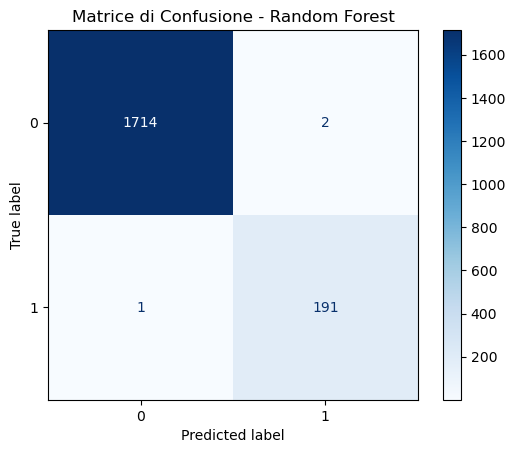

In [73]:
print("\n--- Risultati Finali ---")
print(f"Il miglior modello è: {best_model_name}")
print(f"Con un F1-Score ottimizzato di {best_f1_score:.4f} alla soglia {best_model_threshold:.2f}")

final_y_prob = best_model_instance.predict_proba(X_test_scaled)[:, 1]
final_y_pred = (final_y_prob >= best_model_threshold).astype(int)

print("\nClassification Report Finale (con soglia ottimale):")
print(classification_report(y_test, final_y_pred))

cm = confusion_matrix(y_test, final_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model_instance.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title(f"Matrice di Confusione - {best_model_name}")
plt.show()

In [74]:
model_path = os.path.join('models/best_model.pkl')
scaler_path = os.path.join('models/scaler.pkl')
# salvo il miglior modello e lo scaler
joblib.dump(best_model_instance, model_path)
joblib.dump(scaler, scaler_path)

['models/scaler.pkl']


Feature più importanti secondo il modello:
                            Feature  Importance
5             InsulinaSiericaDueOre    0.539622
2       NumeroTagliCesareiPregressi    0.152809
3          PrecedentePlacentaPrevia    0.146605
7            FecondazioneAssisitita    0.078521
4  SanguinamentiNelSecondoTrimestre    0.054548
1         NumeroGravidanzePregresse    0.014357
0                               Eta    0.007714
6             IndiceDiMassaCorporea    0.005824


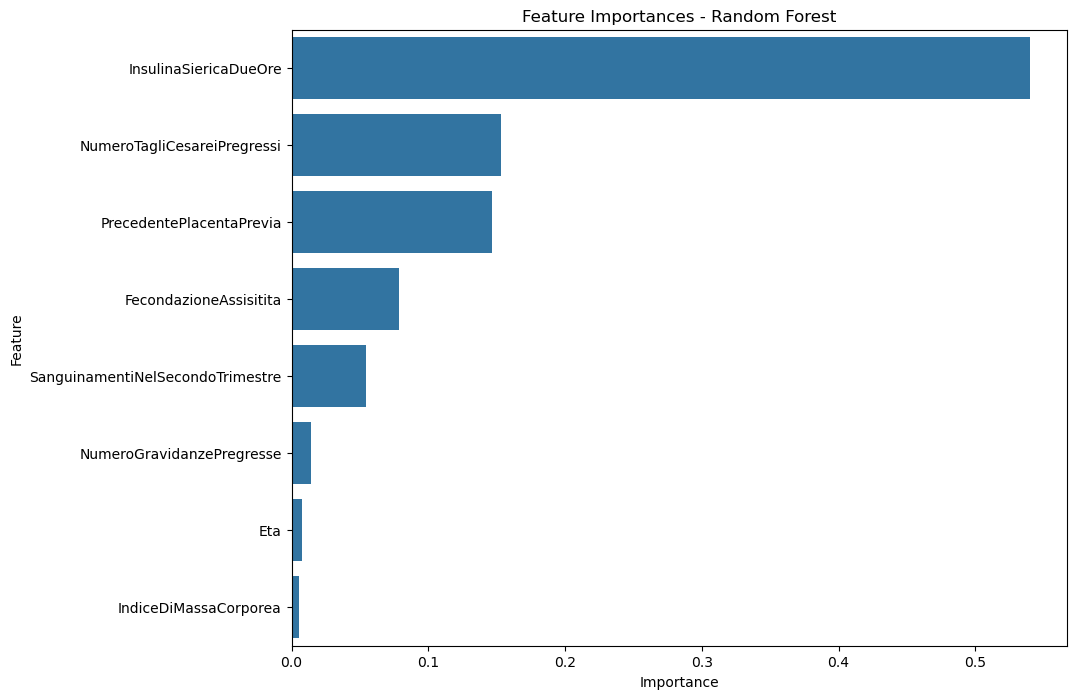

In [75]:
# Estrai le feature importances se il modello le supporta (es. RandomForest, XGBoost)
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_model_instance.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature più importanti secondo il modello:")
print(feature_importances)

# Visualizza le feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title(f'Feature Importances - {best_model_name}')
plt.show()


In [76]:

def PredictPlacentaPrevia(
    Eta: int,
    NumeroGravidanzePregresse: int,
    NumeroTagliCesareiPregressi: int,
    PrecedentePlacentaPrevia: int,
    SanguinamentiNelSecondoTrimestre: int,
    InsulinaSiericaDueOre: float,
    IndiceDiMassaCorporea: float,
    FecondazioneAssisitita: int
) -> tuple[int, float]:
    
    
    MODEL_PATH = 'models/best_model.pkl'
    SCALER_PATH = 'models/scaler.pkl'
    
    # Soglia ottimale per la previsione
    OPTIMAL_THRESHOLD = 0.40

    try: # carico modello e scaler
        model = joblib.load(MODEL_PATH)
        scaler = joblib.load(SCALER_PATH)
    except FileNotFoundError:
        print("Errore: File del modello o dello scaler non trovati. Controllare i percorsi.")
        return -1, -1.0 # Restituisce un valore di errore

    # Elenco delle colonne nell'ordine corretto in cui il modello è stato addestrato
    feature_names = [
        'Eta', 'NumeroGravidanzePregresse', 'NumeroTagliCesareiPregressi',
        'PrecedentePlacentaPrevia', 'SanguinamentiNelSecondoTrimestre',
        'InsulinaSiericaDueOre', 'IndiceDiMassaCorporea', 'FecondazioneAssisitita'
    ]

    # Crea un dizionario con i dati di input
    input_data = {
        'Eta': [Eta],
        'NumeroGravidanzePregresse': [NumeroGravidanzePregresse],
        'NumeroTagliCesareiPregressi': [NumeroTagliCesareiPregressi],
        'PrecedentePlacentaPrevia': [PrecedentePlacentaPrevia],
        'SanguinamentiNelSecondoTrimestre': [SanguinamentiNelSecondoTrimestre],
        'InsulinaSiericaDueOre': [InsulinaSiericaDueOre],
        'IndiceDiMassaCorporea': [IndiceDiMassaCorporea],
        'FecondazioneAssisitita': [FecondazioneAssisitita]
    }
    # Crea un DataFrame dai dati di input
    input_df = pd.DataFrame(input_data, columns=feature_names)

    #Standardizzare i dati di input usando lo scaler addestrato
    input_scaled = scaler.transform(input_df)

    # Calcolare la probabilità usando il modello addestrato
    prob_all_classes = model.predict_proba(input_scaled)
    
    # Estraiamo la probabilità della classe positiva (classe 1)
    prob_positive_class = prob_all_classes[0, 1]

    # Convertire la probabilità in una previsione finale usando la soglia ottimale
    prediction = int(prob_positive_class >= OPTIMAL_THRESHOLD)

    return prediction, prob_positive_class

# test 
previsione, probabilità = PredictPlacentaPrevia(
    Eta=25,
    NumeroGravidanzePregresse=2,
    NumeroTagliCesareiPregressi=2,
    PrecedentePlacentaPrevia=1,
    SanguinamentiNelSecondoTrimestre=1,
    InsulinaSiericaDueOre=110,
    IndiceDiMassaCorporea=32.5,
    FecondazioneAssisitita=0
)
previsione, probabilità

(1, np.float64(0.6275))